# Transient Stability Simulation

Demonstrates the dynamics module's fluent API for configuring and running
transient stability simulations. The notebook covers simulation setup,
contingency definition with the fluent builder, dynamic model inventory,
and result visualization.

In [1]:
from esapp import GridWorkBench, TS
from esapp.components import Bus, Gen

In [2]:
# This cell is hidden in the documentation.
import ast

with open('../data/case.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

wb = GridWorkBench(case_path)

'open' took: 4.1315 sec


Import the case and instantiate the `GridWorkBench`.

```python
from esapp import GridWorkBench, TS
from esapp.components import Bus, Gen

wb = GridWorkBench(case_path)
```

## 1. Simulation Setup

Configure the simulation runtime and specify which fields to record.
The `TS` class provides IDE autocomplete for all transient stability result fields.

In [9]:
# Set simulation duration
wb.dyn.runtime = 10.0

# Watch generator fields during simulation
wb.dyn.watch(Gen, [TS.Gen.P, TS.Gen.W, TS.Gen.Delta])

# Watch bus voltage
wb.dyn.watch(Bus, [TS.Bus.VPU, TS.Bus.Deg]) # TODO remove TS.Bus.FreqMeasT (parsed wrong?)

## 2. Defining Contingencies

The fluent API allows natural definition of timed events using method chaining.

In [10]:
# Define a bus fault contingency
(wb.dyn.contingency("Fault_Bus1")
       .at(1.0).fault_bus("1")         # 3-phase fault at bus 1 at t=1.0s
       .at(1.153).clear_fault("1"))    # Clear after ~9 cycles

print("Contingency 'Fault_Bus1' defined:")
print("  t=1.000s: Apply 3-phase bus fault at Bus 1")
print("  t=1.153s: Clear fault at Bus 1")

Contingency 'Fault_Bus1' defined:
  t=1.000s: Apply 3-phase bus fault at Bus 1
  t=1.153s: Clear fault at Bus 1


## 3. Dynamic Model Inventory

List all dynamic models present in the case. This shows generators, exciters,
governors, and other dynamic models.

In [11]:
models = wb.dyn.list_models()
print("Dynamic Models:")
print(models.to_string())

Dynamic Models:
            Category      Model             Object Type
0            Exciter     ESST1A          Exciter_ESST1A
1            Exciter     ESST4B          Exciter_ESST4B
2            Exciter  EXST1_PTI       Exciter_EXST1_PTI
3            Exciter     IEEET1          Exciter_IEEET1
4            Exciter     REECA1          Exciter_REECA1
5           Governor      GGOV1          Governor_GGOV1
6           Governor     IEEEG1         Governor_IEEEG1
7            Machine     GENROU     MachineModel_GENROU
8            Machine     REGC_A     MachineModel_REGC_A
9   Plant Controller     REPCA1  PlantController_REPCA1
10        Stabilizer     IEEEST       Stabilizer_IEEEST


## 4. Running the Simulation

The `solve()` method runs the transient stability simulation and returns
metadata and time-series results.

In [12]:
meta, results = wb.dyn.solve("Fault_Bus1")

print(f"Metadata shape: {meta.shape}")
print(f"Results shape:  {results.shape}")
print(f"\nMetadata columns: {list(meta.columns)}")
print(f"Time range: {results.index.min():.3f} to {results.index.max():.3f} seconds")

Metadata shape: (209, 6)
Results shape:  (2404, 209)

Metadata columns: ['Object', 'ID-A', 'ID-B', 'Label', 'Metric', 'Contingency']
Time range: 0.000 to 10.000 seconds


## 5. Plotting Results

The built-in `plot()` method creates grouped subplots by object type and field.

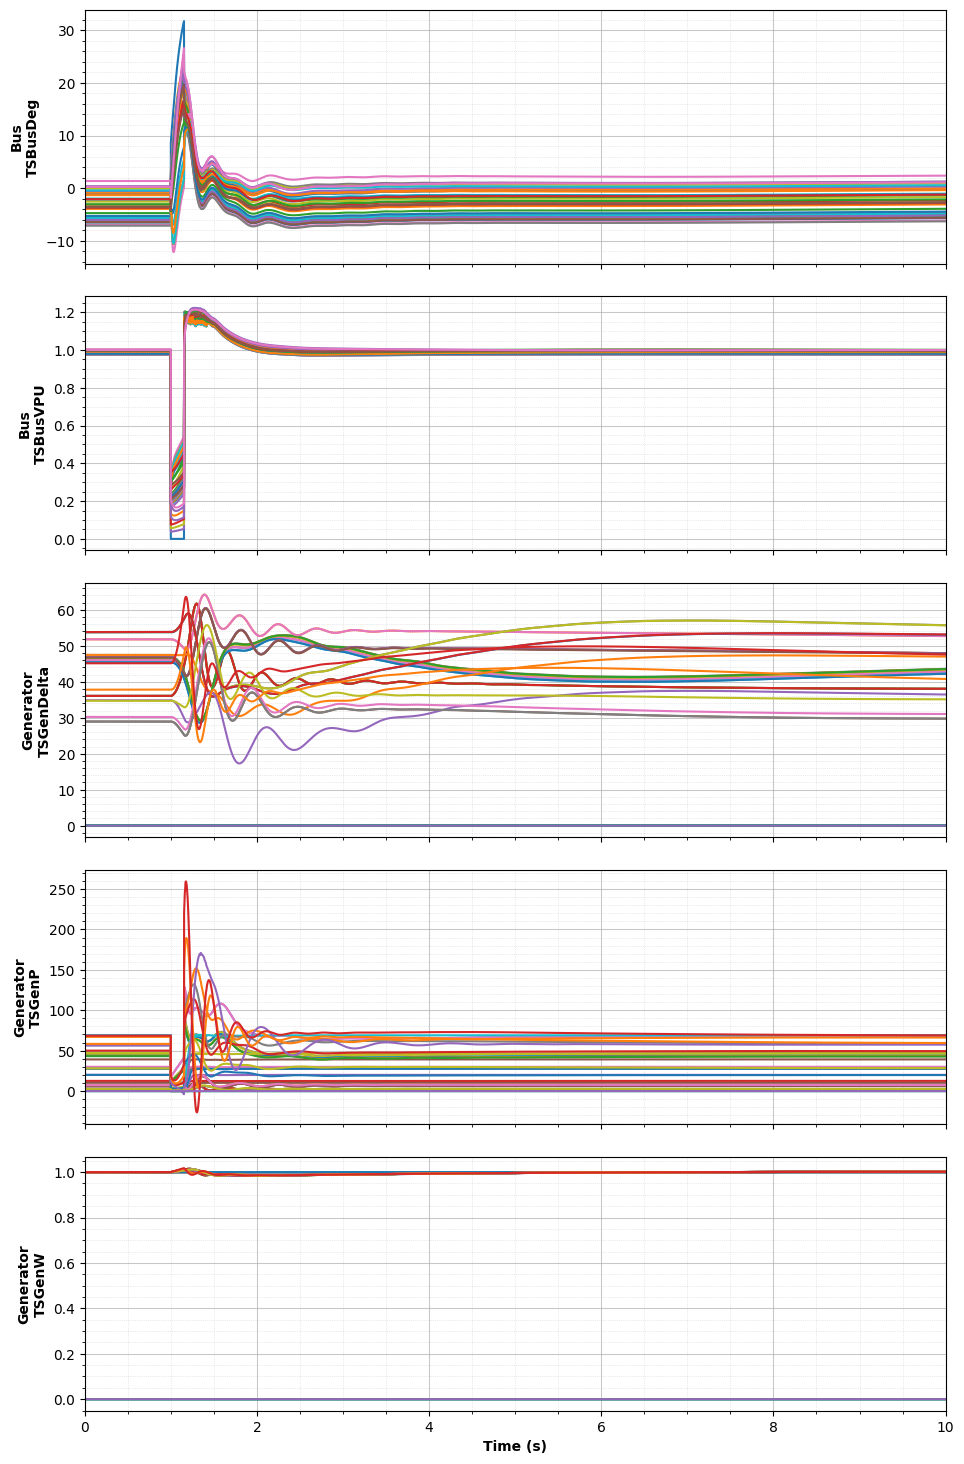

In [13]:
wb.dyn.plot(meta, results)

## Summary

The dynamics module provides a fluent interface for defining contingencies
and running transient stability simulations. Watched fields are recorded
at each time step and can be plotted directly with `wb.dyn.plot()`. Multiple
contingency definitions can coexist for comparative studies.